# Large language models (LLMs): Part II



## Overview
1. Training and inference using Hugging Face
2. Elements of an LLM
3. Attention mechanisms
4. Positional encoding
5. Output layers
6. Training loops

In [1]:
import os
os.environ["HTTP_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["HTTPS_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["http_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["https_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["ftp_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128" 

## LLM training and inference using HuggingFace

### Inference

We can use the Huggingface pipeline with a pretrained GPT2 model to generate text given a prompt.

In [3]:
from transformers import AutoTokenizer,AutoModelForCausalLM, AutoConfig
input_text = "My dog really wanted to"
from transformers import pipeline
generator = pipeline("text-generation", model="openai-community/gpt2")
generator(input_text, max_length=20, num_return_sequences=5)

2024-04-04 20:31:53.301970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/soft/datascience/conda/2023-01-10/mconda3/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


/soft/datascience/conda/2023-01-10/mconda3/lib/python3.10/site-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'My dog really wanted to do that for me. She liked the idea when I went out to eat'},
 {'generated_text': 'My dog really wanted to join us," he says. "It wasn\'t just because she\'s super'},
 {'generated_text': 'My dog really wanted to do this, especially after losing a puppy at a local fair.\xa0 It'},
 {'generated_text': 'My dog really wanted to go with him! She was the first person he ever called home from the'},
 {'generated_text': 'My dog really wanted to love him a lot, and after I lost him I did a lot of'}]

We will cover  evaluation metrics,as well as safe and responsibilities practices when using LLMs in **Session 8**.

### Training

We can also load in our own dataset and train a model with this data as follows:

In [5]:
!pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [6]:
from transformers import TextDataset,DataCollatorForLanguageModeling

def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128) 
    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)   
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset,test_dataset,data_collator

In [8]:
from transformers import AutoTokenizer,AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

train_dataset,test_dataset,data_collator = load_dataset('train_input.txt','test_input.txt', tokenizer)

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./gpt2", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    eval_steps = 40, # Number of update steps between two evaluations.
    save_steps=80, # after # steps model is saved 
    warmup_steps=50,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

Token indices sequence length is longer than the specified maximum sequence length for this model (272065 > 1024). Running this sequence through the model will result in indexing errors


## What is going on below the hood?

Today we will take a closer look at how the model is designed to deal with language.

Let's look inside GPT2! GPT2 incorporates the `GPT2LMHeadModel` architecture so let's inspect this more closely.

In [2]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained('openai-community/gpt2')
print(model)

2024-04-04 20:55:26.214831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/soft/datascience/conda/2023-01-10/mconda3/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

## General elements of an LLM

GPT-2 is an example of the popular Transformer architecture. 


The Transformer-Decoder is composed of Decoder blocks stacked ontop of each other where each contains two types of layers: 
1. Masked Self-Attention and 
2. Feed Forward Neural Networks.

**Let's set up all the imports we will need**

In [3]:
## IMPORTS

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

In our models, we can encode queries, keys, and values using simple linear layers with the same size (`sequence length, head_size`). During the training process, these layers will be updated to best encode context.

In [4]:
C = 32 # channels
head_size = 16

key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

The algorithm for self-attention is as follows:

1. Generate query, key and value vectors for each word
2. Calculate a score for each word in the input sentence against each other.
3. Divide the scores by the square root of the dimension of the key vectors to stabilize the gradients. This is then passed through a softmax operation.
4. Multiply each value vector by the softmax score.
5. Sum up the weighted value vectors to produce the output.


In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# Here we want the wei to be data dependent - ie gather info from the past but in a data dependant way

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16) # each token here (totally B*T) produce a key and query in parallel and independently
q = query(x) # (B, T, 16)
v = value(x)

wei =  q @ k.transpose(-2, -1) * head_size**-0.5 # (B, T, 16) @ (B, 16, T) ---> (B, T, T). #
wei = F.softmax(wei, dim=-1) # exponentiate and normalize giving a nice distibution that sums to 1 and
                             # now it tells us that in a data dependent manner how much of info to aggregate from

out = wei @ v # aggregate the attention scores and value vector.


Let's see how attention is performed in the code.

In [6]:
print(out[0])

tensor([[ 0.0618, -0.0091, -0.3488,  0.3208,  0.2971, -0.1573, -0.0561,  0.1068,
          0.0368,  0.0139, -0.0017,  0.3110,  0.1404, -0.0158,  0.1853,  0.4290],
        [ 0.1578, -0.0971, -0.4256,  0.3538,  0.3621, -0.2392, -0.0536,  0.1759,
          0.1115,  0.0282, -0.0649,  0.3641,  0.1928,  0.0261,  0.2162,  0.3758],
        [ 0.1293,  0.0759, -0.2946,  0.2292,  0.2215, -0.0710, -0.0107,  0.1616,
         -0.0930, -0.0877,  0.0567,  0.1899,  0.0311, -0.0894,  0.0309,  0.5471],
        [ 0.1247,  0.1400, -0.2436,  0.1819,  0.1976,  0.0338, -0.0028,  0.1124,
         -0.1477, -0.0748,  0.0650,  0.1392, -0.0314, -0.0989,  0.0613,  0.5433],
        [ 0.0667,  0.1845, -0.2135,  0.2813,  0.2064,  0.0873,  0.0084,  0.2055,
         -0.1130, -0.1466,  0.0459,  0.1923, -0.0275, -0.1107,  0.0065,  0.4674],
        [ 0.1924,  0.1693, -0.1568,  0.2284,  0.1620,  0.0737,  0.0443,  0.2519,
         -0.1912, -0.1979,  0.0832,  0.0713, -0.0826, -0.0848, -0.1047,  0.6089],
        [ 0.1184,  0.0

### Multi-head attention

In practice, multiple attention heads are used which
1. Expands the model’s ability to focus on different positions and prevent the attention to be dominated by the word itself.
2. Have multiple “representation subspaces”. Have multiple sets of Query/Key/Value weight matrices

### Let's see attention mechanisms in action!

We are going to use the powerful visualization tool bertviz, which allows an interactive experience of the attention mechanisms. Normally these mechanisms are abstracted away but this will allow us to inspect our model in more detail.

In [7]:
!pip install bertviz

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for bertviz from https://files.pythonhosted.org/packages/66/07/cce3d29605a3011d3685b2041fb94fcad25565b80bd2f22f3dcd75b2eee9/bertviz-1.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for boto3 from https://files.pythonhosted.org/packages/50/7f/e0ab195869cedcb65715a87b37b00973b3cf90a0a1b69338ad5bc3c50a3a/boto3-1.34.78-py3-none-any.whl.metadata
  Obtaining dependency information for sentencepiece from https://files.pythonhosted.org/packages/a6/27/33019685023221ca8ed98e8ceb7ae5e166032686fa3662c68f1f1edf334e/sentencepiece-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for botocore<1.35.0,>=1.34.78 from https://files.pythonhosted.org/packages/94/fa/4892ad5b5350b40b8c2892ed2206d0b2550970925f8c5fc0f1b8e648a586/botocore-1.34.78-py3-none-any.whl.metadata
  Obtaining dependency information for jmespath<2.0.0

Let's load in the model, GPT2 and look at the attention mechanisms. 

**Hint... click on the different blocks in the visualization to see the attention**

In [8]:
from transformers import AutoTokenizer, AutoModel, utils, AutoModelForCausalLM

from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

model_name = 'openai-community/gpt2'
input_text = "No, I am your father"  
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>

## Positional encoding

Last week, Carlo discussed token embedding, which is when words are encoded into a vocabulary. Now, we just discussed attention mechanisms which account for context between words. Another question we should ask is how do we account for the order of words in an input sentence

Consider the following two sentences to see why this is important:

``The man ate the sandwich.``

``The sandwich ate the man.``

Clearly, these are two vastly different situations even though they have the same words. The Transformer can 

Transformers differentiate between these situations by adding a **Positional encoding** vector to each input embedding. These vectors follow a specific pattern that the model learns, which helps it determine the position of each word.

<img src="images/positional_encoding.png" alt="Drawing" style="width: 500px;"/>
Image credit: https://medium.com/@xuer.chen.human/llm-study-notes-positional-encoding-0639a1002ec0

We set up positional encoding similarly as token embedding using the ``nn.Embedding`` tool. We use a simple embedding here but there are more complex positional encodings used such as sinusoidal. 

For an explanation of different positional encodings, refer to this post: https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

In [9]:
vocab_size = 65
n_embd = 64

token_embedding_table = nn.Embedding(vocab_size, n_embd)
block_size = 32 # what is the maximum context length for predictions?
position_embedding_table = nn.Embedding(block_size, n_embd)

You will notice the positional encoding size is `(block_size, n_embed)` because it encodes for the postion of a token within the sequence of size `block_size`

Then, the position embedding used is simply added to the token embedding to apply positional embedding.

Let's look at token embedding alone:

In [10]:
x = torch.tensor([1,3,15,4,7,1,4,9])
x = token_embedding_table(x)
print(x[0])

tensor([-9.6630e-05, -1.4031e+00,  6.1625e-01,  3.0717e-02,  1.2290e-01,
        -4.0682e-01,  1.9496e+00,  1.1764e+00, -1.5591e+00,  7.2791e-02,
        -2.3081e+00, -5.0737e-01, -6.9863e-01, -1.3517e+00, -2.1065e-02,
        -9.5309e-01, -1.0516e+00,  7.7541e-02,  4.4402e-01,  8.8709e-01,
         1.8823e-01,  7.1672e-02, -3.4917e-01, -5.7223e-01,  3.5027e-01,
         7.1300e-01, -4.1757e-01,  1.2332e+00, -1.0018e+00,  6.6873e-01,
         9.4601e-03, -1.8759e+00,  3.9894e-01,  6.6391e-01,  6.4071e-02,
         1.6804e+00,  6.2182e-01, -1.6898e+00, -3.4645e-01, -3.1754e+00,
         9.4335e-01,  1.7508e+00, -7.7534e-01, -8.0301e-01,  2.6676e+00,
         3.1534e-01, -5.9224e-01,  4.7193e-01,  6.4641e-01,  4.3199e-01,
         1.4329e+00, -1.0546e+00,  1.6986e+00, -1.2204e+00, -1.2765e-02,
        -1.3485e+00, -4.3946e-01, -1.3725e-01,  4.2354e-01, -4.0840e-01,
        -7.1900e-01, -6.6362e-01, -8.9380e-02,  1.4980e-01],
       grad_fn=<SelectBackward0>)


And token + positional embeddings:

In [11]:
x = torch.tensor([1,3,15,4,7,1,4,9])
x= position_embedding_table(x) + token_embedding_table(x)
print(x[0])

tensor([-1.6103, -1.1454,  0.2832, -0.5627, -0.7867, -0.7475,  1.6190,  0.4168,
        -2.4363,  0.1630, -2.2069,  0.1004,  0.3215, -0.9887, -0.2308,  0.1534,
        -1.2566, -0.2798, -0.0496, -0.0997,  0.9740,  0.4581,  0.7802, -0.1746,
         0.0531, -1.5154,  0.3336,  2.4084, -1.0335,  1.3728, -1.2628, -0.5919,
         0.2460, -0.2431,  2.1009,  0.5958, -0.4106, -2.4724, -1.7571, -3.5932,
         0.4605,  0.8671, -1.9192, -3.0066,  1.6024, -1.5752,  0.7494,  0.8431,
         2.0244,  1.0557,  0.2076,  0.2220,  0.2793, -2.0823,  0.6992, -1.1937,
        -0.3509,  0.8347,  1.0244,  0.5620, -0.3641, -1.3770, -0.1733, -1.4676],
       grad_fn=<SelectBackward0>)


You can see a clear offset between these two embeddings.

During the training process, these embeddings will be learned to best encode the token and positional embeddings of the sequences.

## Output layers

At the end of our Transformer model, we are left with a vector, so how do we turn this into a word?

<img src="images/transformer-decoder-intro.png" alt="Drawing" style="width: 400px;"/>

Using a final Linear layer and a Softmax Layer.
The Linear layer projects the vector produced by the stack of decoders, into a larger vector called a logits vector.

If our model knows 10,000 unique English words learned from its training dataset the logits vector is 10,000 cells wide – each cell corresponds to the score of a unique word.

The softmax layer turns those scores into probabilities. The cell with the highest probability is chosen, and the word associated with it is produced as the output for this time step.

<img src="images/transformer_decoder_output_softmax.png" alt="Drawing" style="width: 450px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

## Training

How does an LLM improve over time?
We want to compare the probabilitiy distribution for each token generated by our model to the ground truths. 
Our model produces a probability distribution for each token. We want to compare these probability distributions to the ground truths. 
For example, when translating the sentence: “je suis étudiant” into “i am a student” as can be seen in the example:

<img src="images/output_target_probability_distributions.png" alt="Drawing" style="width: 500px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

The model can calculate the loss between the vector it generates and the ground truth vector seen in this example. A commonly used loss function is cross entropy loss:

$CE = -\sum_{x \in X} p(x) log q(x)$

where p(x) represents the true distribution and q(x) represents the predicted distribution.

In [12]:
from torch.nn import functional as F
logits = torch.tensor([0.5, 0.1, 0.3])
targets = torch.tensor([1.0, 0.0, 0.0])
loss = F.cross_entropy(logits, targets)
print(loss)

tensor(0.9119)


Another important metric commonly used in LLMs is **perplexity**.

Intuitively, perplexity means to be surprised. We measure how much the model is surprised by seeing new data. The lower the perplexity, the better the training is.

Mathematically, perplexity is just the exponent of the negative cross entropy loss:

$\text{perplexity} = exp(\text{CE})$

In [13]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(2.4891)


In this example, we are using cross entropy loss.

## Let's train a mini-LLM from scratch

### Set up hyperparameters:

In [14]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

### Load in data and create train and test datasets

We're going to be using the tiny Shakespeare dataset. 
Data is tokenized according to a simple character based tokenizer.
Data is split into a train and test set so we have something to test after performing training (9:1 split).

In [28]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

### Set up the components of the Decoder block: 
* MultiHeadAttention
* FeedForward Network

In [29]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


### Combine components into the Decoder block

In [30]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

### Set up the full Transformer model 
This is a combination of the Token embeddings, Positional embeddings, a stack of Transformer blocks and an output block.

In [31]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



We will be training a larger LLM on distributed resources in session 6.

## Homework

1. In this notebook, we learned the various components of an LLM. 
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
      
    Hint: this function might be useful for you:

In [36]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

Running the training loop by chainging a hyperparameter(4 times)

In [37]:
model = LanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
epochs = 20

for j in range(epochs):
    optimizer.zero_grad()
    out = estimate_loss()
    X, Y = get_batch('train')
    _, loss = model(X,Y)
    loss.backward()
    optimizer.step()
        
    print(f"Epoch {j}: train perplexity: {torch.exp(out['train'])} | val perplexity: {torch.exp(out['val'])}")

Epoch 0: train perplexity: 75.23799133300781 | val perplexity: 75.02719116210938
Epoch 1: train perplexity: 145.88137817382812 | val perplexity: 155.3962860107422
Epoch 2: train perplexity: 78.10191345214844 | val perplexity: 81.58261108398438
Epoch 3: train perplexity: 58.79767990112305 | val perplexity: 59.70737838745117
Epoch 4: train perplexity: 56.09406280517578 | val perplexity: 56.9787483215332
Epoch 5: train perplexity: 46.55436325073242 | val perplexity: 47.963199615478516
Epoch 6: train perplexity: 36.43805694580078 | val perplexity: 37.21160888671875
Epoch 7: train perplexity: 28.999666213989258 | val perplexity: 29.548044204711914
Epoch 8: train perplexity: 26.383377075195312 | val perplexity: 27.098905563354492
Epoch 9: train perplexity: 27.62305450439453 | val perplexity: 28.553525924682617
Epoch 10: train perplexity: 26.92572784423828 | val perplexity: 28.027746200561523
Epoch 11: train perplexity: 26.851734161376953 | val perplexity: 27.97960090637207
Epoch 12: train pe

In [42]:
import matplotlib.pyplot as plt
from collections import defaultdict

# hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4

perplexities = defaultdict(lambda: defaultdict(list))
n_embds = [32, 64, 128, 512]
for n_embd in n_embds:
    model = LanguageModel().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

    for j in range(epochs):
        optimizer.zero_grad()
        out = estimate_loss()
        X, Y = get_batch('train')
        _, loss = model(X,Y)
        loss.backward()
        optimizer.step()
        perplexities[n_embd]['train'].append(torch.exp(out['train']))
        perplexities[n_embd]['val'].append(torch.exp(out['val']))

Text(0, 0.5, 'Perplexity')

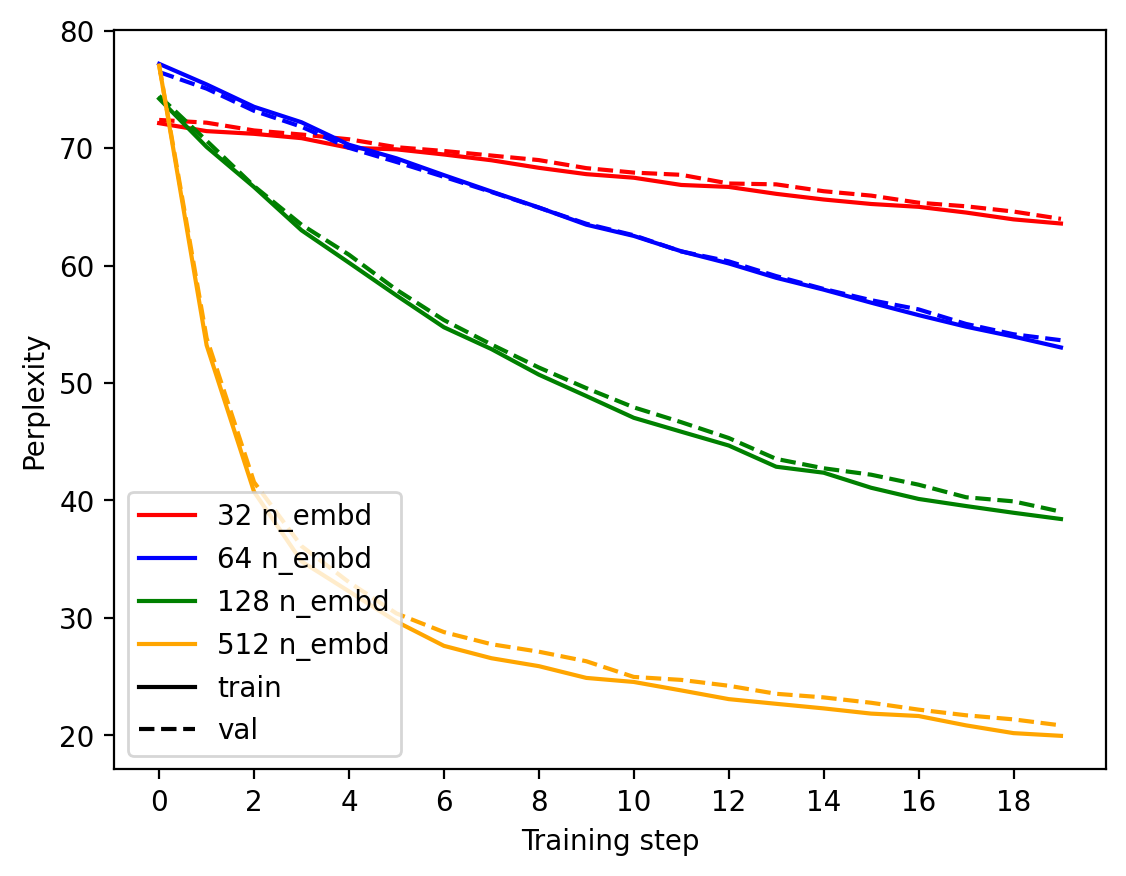

In [43]:
fig = plt.figure(dpi = 200)
epoch = list(range(epochs))
colors = ['red', 'blue', 'green', 'orange']

for i, n_embd in enumerate(perplexities):
    plt.plot(epoch, perplexities[n_embd]['train'], color = colors[i], label = f'{n_embd} n_embd')
    plt.plot(epoch, perplexities[n_embd]['val'], color = colors[i], ls = '--')
plt.plot([], [], label = 'train', color = 'k')
plt.plot([], [], label = 'val', ls = '--', color = 'k')

plt.xticks(ticks=epoch[::2])
plt.legend()
plt.xlabel('Training step')
plt.ylabel('Perplexity')

As the n_embds increasing the model is getting better and better. We use the learning rate 0.0001, and decay rate 0.01. 


In [46]:
import torch
import torch.nn.functional as F

def generate_text(model, start_token, max_length=100, temperature=1.0):
    end_of_sequence_token = tokenizer.eos_token_id
    
    with torch.no_grad():
        current_token = start_token
        generated_text = [current_token]
        
        for _ in range(max_length):
            input_tensor = torch.tensor([[current_token]]).to(device)
            logits, _ = model(input_tensor)
            next_token_probs = F.softmax(logits[:, -1, :] / temperature, dim=-1).squeeze()
            sampled_token = torch.multinomial(next_token_probs, 1).item()
            
            if sampled_token == end_of_sequence_token:
                break
            elif sampled_token == tokenizer.unk_token_id:
                continue
            
            generated_text.append(sampled_token)
            current_token = sampled_token
            
        generated_text = generated_text[1:]  # Remove start token
        generated_text = [str(token) for token in generated_text]
        return ' '.join(generated_text)

# Generate text from each trained model
for n_embd in n_embds:
    model = LanguageModel().to(device)
    # Assuming LanguageModel is your model class
    # You need to replace this with your actual model initialization code
    
    print(f"Generated text with n_embd={n_embd}:")
    start_token = tokenizer.bos_token_id  # Beginning-of-sequence token
    generated_text = generate_text(model, start_token)
    print(generated_text)



Generated text with n_embd=32:


/soft/datascience/conda/2023-01-10/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1088: indexSelectSmallIndex: block: [0,0,0], thread: [0,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/soft/datascience/conda/2023-01-10/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1088: indexSelectSmallIndex: block: [0,0,0], thread: [1,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/soft/datascience/conda/2023-01-10/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1088: indexSelectSmallIndex: block: [0,0,0], thread: [2,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/soft/datascience/conda/2023-01-10/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1088: indexSelectSmallIndex: block: [0,0,0], thread: [3,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/soft/datascience/conda/2023-01-10/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1088: indexSelectSmallIndex: block: [0,0,0], thread: [4,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/soft/datascience/conda/2023-01-10/pytorch/aten/sr

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.